In [30]:
import numpy as np
from typing import Any
from matplotlib import pyplot as plt
from abc import ABC, abstractmethod

In [31]:
class BasisFitter(ABC):
    
    @abstractmethod
    def get_phi(self, k:int, X: np.ndarray) -> np.ndarray:
        """Returns the basis matrix to transform input data."""

    def fit(self, k: int, X_train: np.ndarray, y_train: np.ndarray) -> tuple[np.ndarray, np.floating[Any]]:
        """Fits basis to given training data and returns weights and MSE."""
        assert X_train.ndim == 1
        assert y_train.ndim == 1
        phi = self.get_phi(k, X_train)
        m = len(X_train)
        w = np.linalg.inv(phi.T @ phi) @ (phi.T @ y_train)
        sse = np.linalg.norm(np.dot(phi, w) - y_train)**2
        mse = sse/m
        return w, mse

# 1.1 Linear Regression

## 1.1.1 Polynomial basis fitting

In [32]:
class PolynomialBasisFitter(BasisFitter):

    def get_phi(self, k, X):
        return X.reshape(-1, 1) ** np.arange(k)


Fitting basis polynomial with dimension 1: 
MSE: 3.2499999999999996
w: [2.5] 


Fitting basis polynomial with dimension 2: 
MSE: 3.05
w: [1.5 0.4] 


Fitting basis polynomial with dimension 3: 
MSE: 0.7999999999999999
w: [ 9.  -7.1  1.5] 


Fitting basis polynomial with dimension 4: 
MSE: 4.415399636928564e-24
w: [-5.         15.16666667 -8.5         1.33333333] 




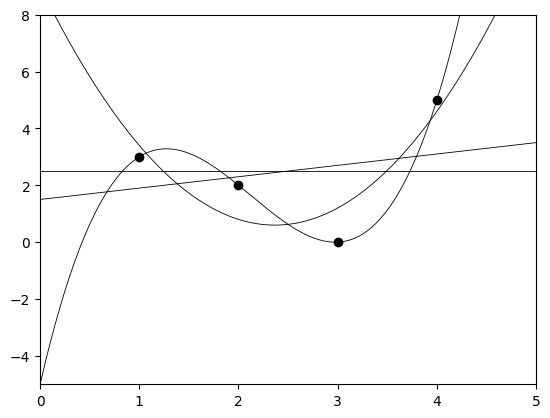

In [33]:
# training data
X = np.array([1, 2, 3, 4])
y = np.array([3, 2, 0, 5])

plt.scatter(X, y, color='k')

for k in range(1, 5):
    w, mse = PolynomialBasisFitter().fit(k, X, y)
    print(f"Fitting basis polynomial with dimension {k}: ")
    print(f"MSE: {mse}")
    print(f"w: {w} \n\n")
    x_values = np.linspace(0, 5, 200)
    y_values = np.dot(x_values.reshape(-1, 1) ** np.arange(k), w)
    plt.plot(x_values, y_values, 'k', linewidth=0.6)

    
plt.xlim(0, 5)
plt.ylim(-5, 8)
plt.show()



## 1.1.2 Overfitting demonstration

In [34]:
def generate_data_set(sigma: float, n: int) -> tuple[np.ndarray, np.ndarray]:
    """Gives n random training data points based on squared sine function with noise."""
    X = np.random.uniform(0, 1, n) # sampling n values from uniform distribution
    y = np.sin(2*np.pi*X)**2 + sigma*np.random.standard_normal(n)
    return X, y

X_train, y_train = generate_data_set(0.07, 30)

### Part (a)

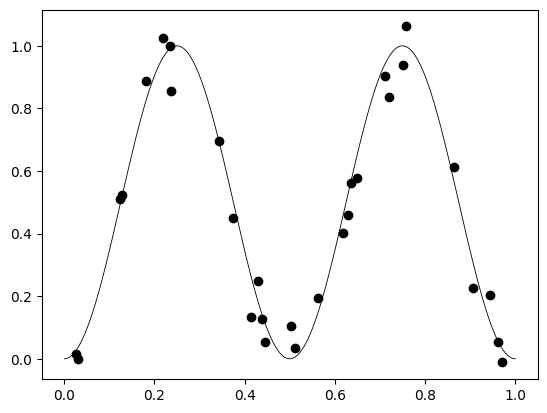

In [35]:
plt.scatter(X_train, y_train, color='k')

x_values = np.linspace(0, 1, 500)
y_values = np.sin(2*np.pi*x_values) ** 2
plt.plot(x_values, y_values, 'k', linewidth=0.6)

    

plt.show()

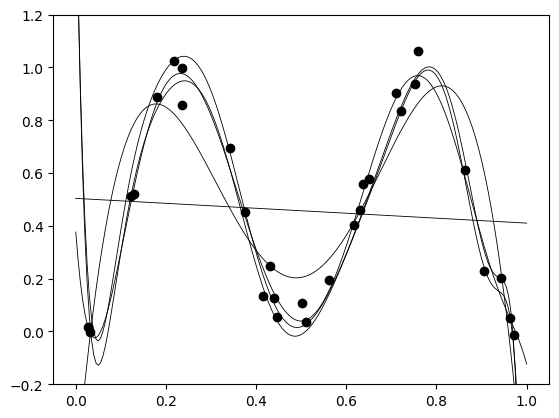

In [36]:
plt.scatter(X_train, y_train, color='k')

k_values = [2, 5, 10, 14, 18]

for k in k_values:
    w, mse = PolynomialBasisFitter().fit(k, X_train, y_train)
    x_values = np.linspace(0, 1, 200)
    y_values = np.dot(x_values.reshape(-1, 1) ** np.arange(k), w)
    plt.plot(x_values, y_values, 'k', linewidth=0.6)

    
plt.ylim(-0.2, 1.2)
plt.show()

### Part (b)

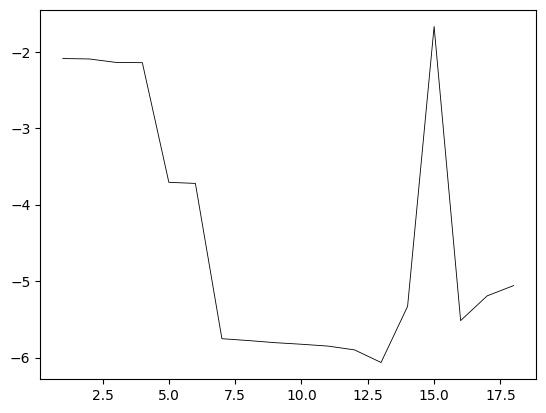

In [37]:
k_values = np.arange(1, 19)
vectorised_train_error = np.vectorize(lambda k : PolynomialBasisFitter().fit(k, X_train, y_train)[1]) # vectorized function to get mse of a k dimension polynomial basis fit to X_train, y_train


log_train_errors = np.log(vectorised_train_error(k_values))

plt.plot(k_values, log_train_errors , 'k', linewidth=0.6)


### Part (c)

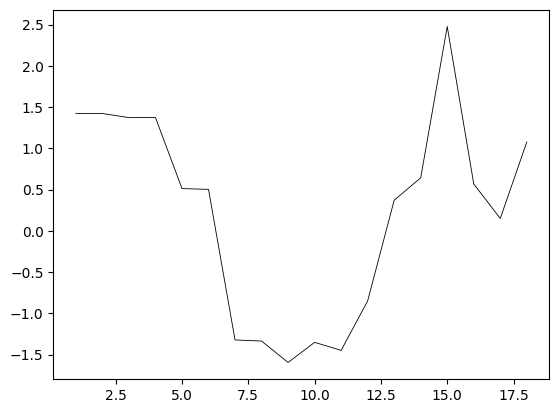

In [38]:
def test_error(model: BasisFitter, k : int, X_train: np.ndarray, y_train: np.ndarray, X_test: np.ndarray, y_test: np.ndarray):
    w, _ = model.fit(k, X_train, y_train)
    basis = model.get_phi(k, X_test)
    mse = np.linalg.norm(np.dot(basis, w) - y_test)**2 / len(X_train)
    return mse


X_test, y_test = generate_data_set(0.07, 1000)

vectorized_test_error = np.vectorize(lambda k : test_error(PolynomialBasisFitter(), k, X_train, y_train, X_test, y_test))
log_test_errors = np.log(vectorized_test_error(k_values))

plt.plot(k_values, log_test_errors , 'k', linewidth=0.6)



### Part (d)

In [39]:
# Reusing parts (b) and (c) but extending for repeated runs and averaging

def get_log_avg_train_error(model: BasisFitter, k_values, N: int):
    """Does N runs of fitting polynomial basis to random sin squared distribution to get ln(average MSE on training data)."""

    train_errors = []

    for _ in range(N):
        X_train, y_train = generate_data_set(0.07, 30)
        vectorised_train_error = np.vectorize(lambda k : model.fit(k, X_train, y_train)[1]) 
        train_errors.append(vectorised_train_error(k_values))

    return np.log(np.mean(train_errors, axis=0))
    

def get_log_avg_test_error(model: BasisFitter, k_values, N: int):
    """Does N runs of fitting polynomial basis to random sin squared distribution to get ln(average MSE on test data)."""

    test_errors = []

    for _ in range(N):
        X_train, y_train = generate_data_set(0.07, 30)
        X_test, y_test = generate_data_set(0.07, 1000) 
        vectorized_test_error = np.vectorize(lambda k : test_error(model, k, X_train, y_train, X_test, y_test))
        test_errors.append(vectorized_test_error(k_values))
        
    test_errors = np.array(test_errors)

    return np.log(np.mean(test_errors, axis=0))
    

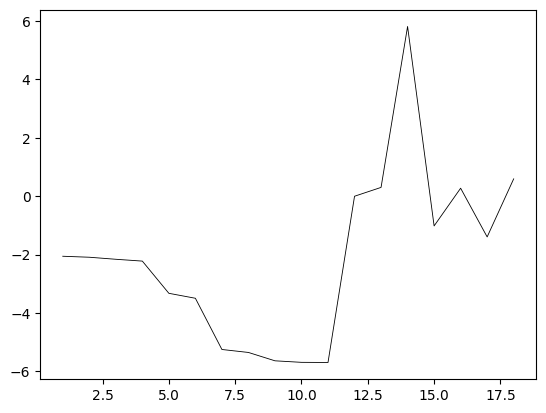

In [40]:
# Plotting ln(average training error)
k_values = np.arange(1, 19)

plt.plot(k_values, get_log_avg_train_error(PolynomialBasisFitter(), k_values, 100) , 'k', linewidth=0.6)


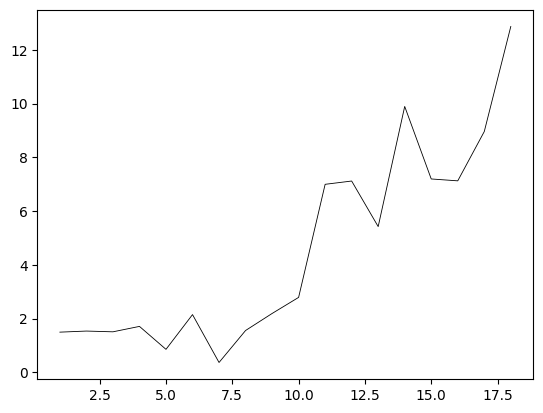

In [41]:
# Plotting ln(average test error)

plt.plot(k_values, get_log_avg_test_error(PolynomialBasisFitter(), k_values, 100) , 'k', linewidth=0.6)

## 1.1.3 Repeating experiments in 1.1.2 parts b to d with a new basis

In [42]:

class TrigBasisFitter(BasisFitter):

    def get_phi(self, k, X):
        scaling = np.pi * np.arange(1, k+1)
        
        phi = np.sin(X.reshape(-1, 1) * scaling)

        return np.sin(phi)
    

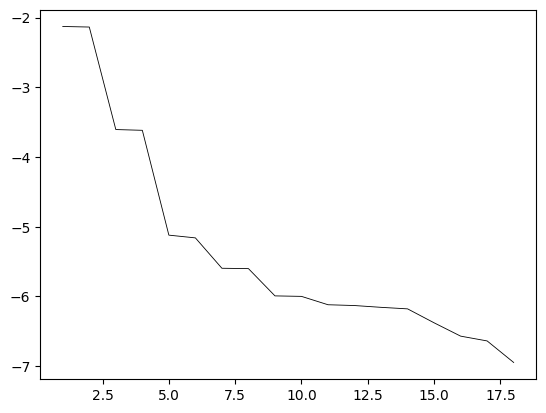

In [43]:
# single run average training error


X_train, y_train = generate_data_set(0.07, 30)

k_values = np.arange(1, 19)
vectorised_train_error = np.vectorize(lambda k : TrigBasisFitter().fit(k, X_train, y_train)[1]) 

log_train_errors = np.log(vectorised_train_error(k_values))

plt.plot(k_values, log_train_errors , 'k', linewidth=0.6)

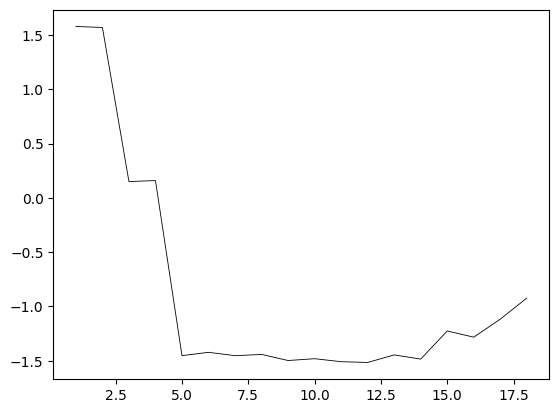

In [44]:
# single run average testing error


X_test, y_test = generate_data_set(0.07, 1000)

vectorized_test_error = np.vectorize(lambda k : test_error(TrigBasisFitter(), k, X_train, y_train, X_test, y_test))
log_test_errors = np.log(vectorized_test_error(k_values))

plt.plot(k_values, log_test_errors , 'k', linewidth=0.6)

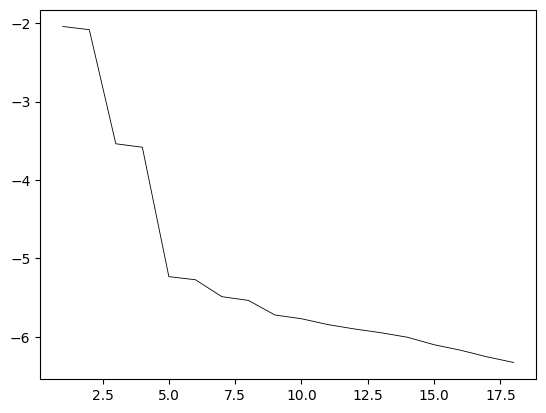

In [45]:
# Plotting ln(average training error)
k_values = np.arange(1, 19)

plt.plot(k_values, get_log_avg_train_error(TrigBasisFitter(), k_values, 100) , 'k', linewidth=0.6)

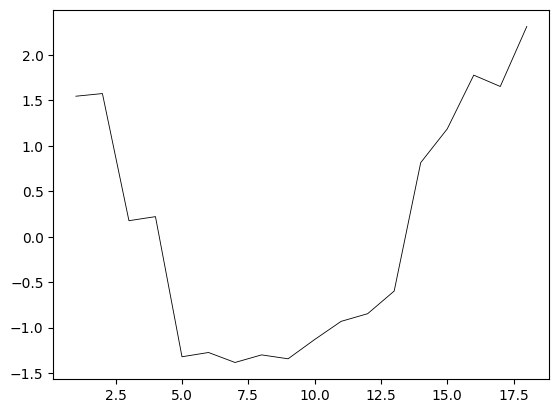

In [46]:
# Plotting ln(average test error)

plt.plot(k_values, get_log_avg_test_error(TrigBasisFitter(), k_values, 100) , 'k', linewidth=0.6)